Муртазалиев Матвей, 466797, J3110

## 1. Загрузка данных

In [8]:
# Импорт библиотек
import pandas as pd
import numpy as np
import re
import os
import warnings
import math
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

# Cкачиваем словари при первом запуске
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style('whitegrid')

In [2]:
# Чтение файлов
DATA_DIR = '../data'
questions = pd.read_csv(os.path.join(DATA_DIR, 'Questions.csv'), encoding='latin1', parse_dates=['CreationDate', 'ClosedDate'])
answers = pd.read_csv(os.path.join(DATA_DIR, 'Answers.csv'), encoding='latin1', parse_dates=['CreationDate'])
tags = pd.read_csv(os.path.join(DATA_DIR, 'Tags.csv'), encoding='latin1')

print('Questions:', questions.shape)
print('Answers  :', answers.shape)
print('Tags     :', tags.shape)


Questions: (1264216, 7)
Answers  : (2014516, 6)
Tags     : (3750994, 2)


In [3]:
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01 13:57:07+00:00,NaT,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26 03:45:49+00:00,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01 15:50:08+00:00,NaT,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01 18:42:19+00:00,NaT,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01 23:22:08+00:00,NaT,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [4]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01 14:45:37+00:00,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01 16:09:47+00:00,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01 19:36:46+00:00,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01 23:49:57+00:00,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02 01:49:46+00:00,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [5]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [6]:
# Соединяем вопросы с ответами
answers_per_question = answers.groupby('ParentId').size().rename('AnswerCount') # answers.ParentId ссылается на Questions.Id
questions = questions.merge(answers_per_question, left_on='Id', right_index=True, how='left')
questions['AnswerCount'] = questions['AnswerCount'].fillna(0).astype(int)

# Объединяем теги и получаем список тегов для каждого вопроса
tags_agg = tags.groupby('Id')['Tag'].apply(list).rename('TagList')
questions = questions.merge(tags_agg, left_on='Id', right_index=True, how='left')

questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,AnswerCount,TagList
0,80,26.0,2008-08-01 13:57:07+00:00,NaT,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,3,"[flex, actionscript-3, air]"
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26 03:45:49+00:00,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,3,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,83.0,2008-08-01 15:50:08+00:00,NaT,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,1,"[sql, asp.net, sitemap]"
3,180,2089740.0,2008-08-01 18:42:19+00:00,NaT,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,9,"[algorithm, language-agnostic, colors, color-s..."
4,260,91.0,2008-08-01 23:22:08+00:00,NaT,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,9,"[c#, .net, scripting, compiler-construction]"


## 2. Очистка текста


In [9]:
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# from bs4 import BeautifulSoup
# def strip_html(raw_html: str) -> str:
#     soup = BeautifulSoup(str(raw_html), 'html.parser')
#     for code in soup.find_all('code'):
#         code.decompose()
#     text = soup.get_text(" ")
#     return text

# Функция для определения части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def normalize(text: str) -> str:
    # Убираем теги
    text = re.sub(r'<code.*?>.*?</code>', '', text, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r'<[^>]+>', ' ', text)
    # В нижний шрифт
    text = text.lower()
    # Убираем markdown и ссылки
    text = re.sub(r'http\S+|www\S+', ' ', text)
    # Оставляем только буквы/цифры
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Преобразуем в начальную форму
    tokens = [lemmatizer.lemmatize(tok, get_wordnet_pos(tok)) for tok in text.split() if tok not in STOPWORDS and len(tok) > 2]
    return ' '.join(tokens)

# Демонстрация работы
sample_clean = normalize(questions.iloc[0]['Body'])
print(sample_clean[:300])

write database generation script sql want execute adobe air application execute adobe air use follow method error generate however exists seem look first query semicolon remove query fails way call multiple query one statement


In [10]:
# Применяем очистку ко всему датасету
questions['CleanBody'] = questions['Body'].apply(normalize)
questions['CleanTitle'] = questions['Title'].apply(lambda t: normalize(str(t)))
questions.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,AnswerCount,TagList,CleanBody,CleanTitle
0,80,26.0,2008-08-01 13:57:07+00:00,NaT,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,3,"[flex, actionscript-3, air]",write database generation script sql want exec...,sqlstatement execute multiple query one statement
1,90,58.0,2008-08-01 14:41:24+00:00,2012-12-26 03:45:49+00:00,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,3,"[svn, tortoisesvn, branch, branching-and-merging]",really good tutorial explain branching merge a...,good branching merge tutorial tortoisesvn
2,120,83.0,2008-08-01 15:50:08+00:00,NaT,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,1,"[sql, asp.net, sitemap]",anyone get experience create sql base asp net ...,asp net site map
3,180,2089740.0,2008-08-01 18:42:19+00:00,NaT,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,9,"[algorithm, language-agnostic, colors, color-s...",something pseudo solve many time never quite f...,function create color wheel
4,260,91.0,2008-08-01 23:22:08+00:00,NaT,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,9,"[c#, .net, scripting, compiler-construction]",little game write us database back end trading...,add script functionality net application


In [11]:
questions.to_csv(DATA_DIR + '/Questions_cleared.csv', index=False)

In [12]:
answers['CleanBody'] = answers['Body'].apply(normalize)
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,CleanBody
0,92,61.0,2008-08-01 14:45:37+00:00,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers...",version control subversion good resource sourc...
1,124,26.0,2008-08-01 16:09:47+00:00,80,12,<p>I wound up using this. It is a kind of a ha...,wound use kind hack actually work pretty well ...
2,199,50.0,2008-08-01 19:36:46+00:00,180,1,<p>I've read somewhere the human eye can't dis...,read somewhere human eye distinguish less valu...
3,269,91.0,2008-08-01 23:49:57+00:00,260,4,"<p>Yes, I thought about that, but I soon figur...",yes thought soon figure another domain specifi...
4,307,49.0,2008-08-02 01:49:46+00:00,260,28,"<p><a href=""http://www.codeproject.com/Article...",oleg shilo script solution code project really...


In [13]:
answers.to_csv(DATA_DIR + '/Answers_cleared.csv', index=False)

##  3. Агрегация и регуляризация

In [41]:
# Количество вопросов и ответов
N = len(questions)
mean_ans = questions['AnswerCount'].mean()
median_ans = questions['AnswerCount'].median()
max_ans = questions['AnswerCount'].max()

print(f'Total questions: {N:,}')
print(f'Average answers per question: {mean_ans:.2f}')
print(f'Median answers per question : {median_ans}')
print(f'Max answers per question    : {max_ans}')

Total questions: 1,264,216
Average answers per question: 1.59
Median answers per question : 1.0
Max answers per question    : 408


In [42]:
# Топ 10 популярных тегов (включая языки программирования)
tag_counts = tags['Tag'].value_counts().head(10)
tag_counts

Tag
javascript    124155
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: count, dtype: int64

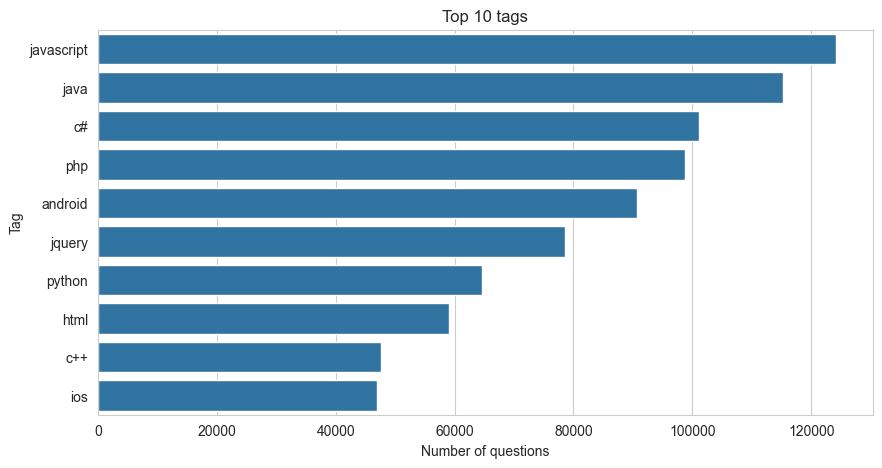

In [43]:
sns.barplot(x=tag_counts.values, y=tag_counts.index)
plt.title('Top 10 tags')
plt.xlabel('Number of questions')
plt.ylabel('Tag');

## 4. Первичный анализ и визуализация

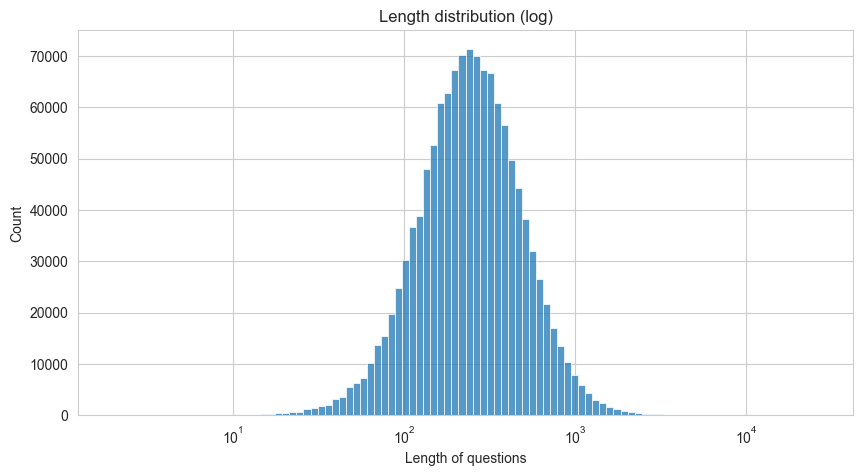

In [44]:
# Длина вопросов (очищенных)
questions['QLength'] = questions['CleanBody'].str.len()
sns.histplot(questions['QLength'], bins=100, log_scale=True)
plt.xlabel('Length of questions')
plt.title('Length distribution (log)');

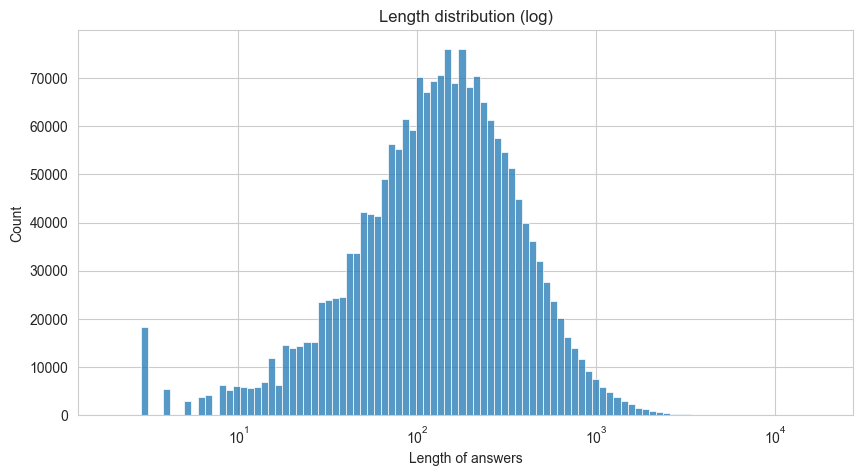

In [45]:
# Длина ответов (очищенных)
answers['ALength'] = answers['CleanBody'].str.len()
sns.histplot(answers['ALength'], bins=100, log_scale=True)
plt.xlabel('Length of answers')
plt.title('Length distribution (log)');

In [46]:
# Проверка пропусков
missing = questions.isna().mean().sort_values(ascending=False)
missing.head(10)

ClosedDate      0.955736
OwnerUserId     0.011433
Id              0.000000
CreationDate    0.000000
Score           0.000000
Title           0.000000
Body            0.000000
AnswerCount     0.000000
TagList         0.000000
CleanBody       0.000000
dtype: float64

## 5. Выводы
* **Объем:** $N \approx$ 1.26 млн вопросов и 2.6 млн ответов, а также около 37000 уникальных тегов.
* **Среднее число ответов** на вопрос ≈ 1.5, однако медиана = 1, значит распределение правостороннее
* **Популярные теги:** `javascript`, `java`, `c#`, `php`, `android`, …
* **Размер текста:** большинство вопросов укладывается в 500–1500 символов
* **Пропуски** их немного — в основном `ClosedDate`, но это норма
